In [1]:
import pandas as pd

# loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')
print(df.head())
print(df.info())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

In [2]:
import numpy as np

# Detecting outliers using IQR
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Handling outliers by capping
df['amount'] = np.where(df['amount'] < lower_bound, lower_bound, df['amount'])
df['amount'] = np.where(df['amount'] > upper_bound, upper_bound, df['amount'])


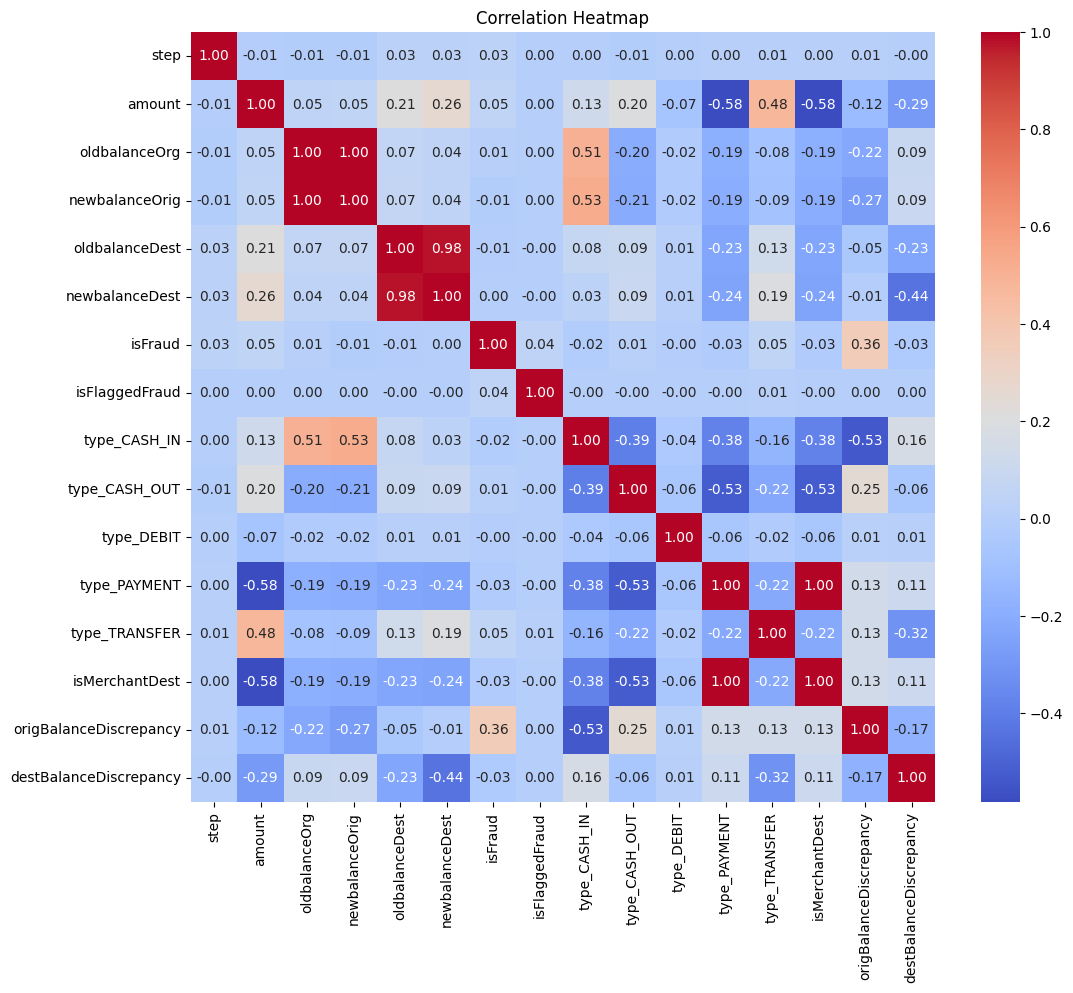

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr = df.corr()

# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [3]:
# Encode transaction types
df = pd.get_dummies(df, columns=['type'])

# Flag for merchant accounts in destination
df['isMerchantDest'] = df['nameDest'].apply(lambda x: 1 if x.startswith('M') else 0)

# Discrepancy in balance for origin and destination accounts
df['origBalanceDiscrepancy'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['destBalanceDiscrepancy'] = df['oldbalanceDest'] - df['newbalanceDest']

# Dropping unnecessary columns
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [7]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [8]:
from sklearn.metrics import classification_report

# Evaluation for RandomForestClassifier
rf_predictions = rf.predict(X_test)
print("RandomForestClassifier Evaluation")
print(classification_report(y_test, rf_predictions))

# Evaluation for XGBoost
xgb_predictions = xgb.predict(X_test)
print("XGBoost Evaluation")
print(classification_report(y_test, xgb_predictions))


RandomForestClassifier Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.80      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

XGBoost Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.80      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



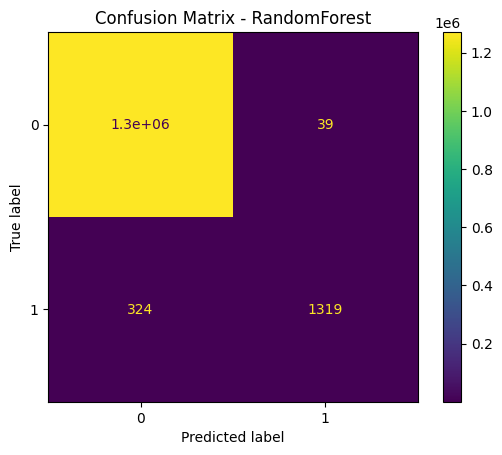

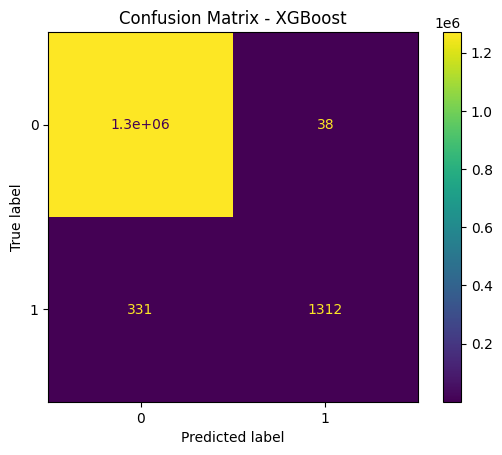

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for RandomForestClassifier
cm_rf = confusion_matrix(y_test, rf_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()
plt.title('Confusion Matrix - RandomForest')
plt.show()

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, xgb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot()
plt.title('Confusion Matrix - XGBoost')
plt.show()


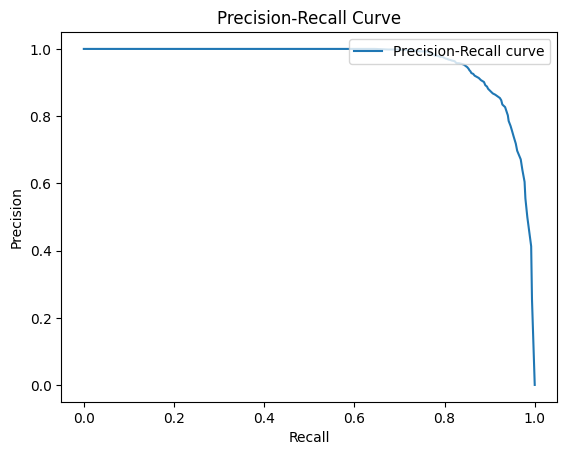

In [12]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()
